In [1]:
import pandas as pd

In [67]:
import matplotlib.pyplot as plt

In [80]:
import matplotlib

In [2]:
from sklearn.decomposition import PCA
import numpy as np

In [23]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [467]:
from sklearn.preprocessing import StandardScaler

In [117]:
from sklearn.model_selection import cross_val_score

In [448]:
#subset = ['Home','teamPF_T6_x','teamFT%_T6_x','teamBLKR_T6_x','teamPPS_T6_x','teamEDiff_T6_x','teamSTL/TO_T6_x','teamTREB%_T6_y',
 #'teamBLKR_T6_y','teamPPS_T6_y','teamAST/TO_T6_y','teamSTL/TO_T6_y']

## Next test is to change the trailing averages of the original data and compare r2 results at different trailing amounts
#### From results above, I don't know which features will be more signficant if you increase/decrease trailing average so will use PCA on all components
##### therefore at each trailling average amount I will:
- Standardize X values
- Transform X Values with PCA at .95 level
- Predict target variable with components at different levels of alpha within Cross Validated Lasso Regression
- Record best result at best alpha
- visualize results

In [191]:
nba = pd.read_csv('2017-18_teamBoxScore.csv')
nba.head()

,PrimKey,opptKey,gmDate,teamAbbr,teamLoc,teamRslt,teamMin,teamDayOff,teamPTS,teamAST,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,43025BOS,43025CLE,10/17/2017,BOS,Away,Loss,241,0,99,24,...,55.5208,101.7143,98.7227,2.9916,0.4176,14.6154,1.1176,17.6471,100.2809,99.8648
1,43025CLE,43025BOS,10/17/2017,CLE,Home,Win,240,0,102,19,...,62.5519,98.7227,101.7143,-2.9916,0.3956,17.7778,2.0000,91.6667,100.2809,100.2809
2,43025HOU,43025GS,10/17/2017,HOU,Away,Win,239,0,122,28,...,86.2033,118.0353,119.0108,-0.9755,0.4725,24.2442,2.0000,29.4118,102.5117,102.9406
3,43025GS,43025HOU,10/17/2017,GS,Home,Loss,241,0,121,34,...,81.9038,119.0108,118.0353,0.9755,0.4700,19.1309,2.1538,69.2308,102.5117,102.0863
4,43026CHA,43026DET,10/18/2017,CHA,Away,Loss,238,0,90,16,...,70.7113,103.0506,90.9270,12.1236,0.4271,17.8731,2.6667,155.5556,98.9805,99.8123


In [192]:
#select columns that are numeric for trailing calc
nba_numbers = nba.select_dtypes(exclude='object')
a = pd.DataFrame(nba['PrimKey'])
nba_numbers = nba_numbers.merge(a,left_index=True, right_index=True)
nba_numbers.head()

,teamMin,teamDayOff,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,...,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace,PrimKey
0,241,0,99,24,12,11,4,24,88,36,...,101.7143,98.7227,2.9916,0.4176,14.6154,1.1176,17.6471,100.2809,99.8648,43025BOS
1,240,0,102,19,17,3,4,25,83,38,...,98.7227,101.7143,-2.9916,0.3956,17.7778,2.0000,91.6667,100.2809,100.2809,43025CLE
2,239,0,122,28,13,9,5,16,97,47,...,118.0353,119.0108,-0.9755,0.4725,24.2442,2.0000,29.4118,102.5117,102.9406,43025HOU
3,241,0,121,34,17,5,9,25,80,43,...,119.0108,118.0353,0.9755,0.4700,19.1309,2.1538,69.2308,102.5117,102.0863,43025GS
4,238,0,90,16,17,4,3,15,73,29,...,103.0506,90.9270,12.1236,0.4271,17.8731,2.6667,155.5556,98.9805,99.8123,43026CHA


In [193]:
num_fields = nba_numbers.columns.tolist()

In [409]:
#exclude fields that don't make sense to do a trailing average of
exclude = ['teamDayOff']
team_fields = [x for x in num_fields if x not in exclude]
#exclude opponent stats as it is redudant 
#as there is a line for the same game for the opponent too and 
#will merge that back later
team_fields = [x for x in team_fields if 'oppt' not in x]

In [195]:
#remove PrimKey
trailing_fields = [x for x in team_fields if x != 'PrimKey']

In [293]:
len(trailing_fields)

44

In [196]:
#get team names for loop below
teams = nba['teamAbbr'].unique()
len(teams) #correct should be 30

30

In [408]:
#create final set to merge with
#home/away, days off, and the dependent variable margin of victory

#dependent
nba['MarginOfVictory'] = nba['teamPTS'] - nba['opptPTS']
#dummy home
home = pd.get_dummies(nba['teamLoc'])
home = home['Home']
nba['Home'] = home
#final selection
nba_final = nba[['PrimKey','opptKey','teamAbbr','MarginOfVictory','teamDayOff','Home']]
nba_final = nba_final.merge(nba[['PrimKey','teamDayOff']], left_on='opptKey', right_on='PrimKey')
nba_final.drop(columns='PrimKey_y', inplace=True)
nba_final.head()

,PrimKey_x,opptKey,teamAbbr,MarginOfVictory,teamDayOff_x,Home,teamDayOff_y
0,43025BOS,43025CLE,BOS,-3,0,0,0
1,43025CLE,43025BOS,CLE,3,0,1,0
2,43025HOU,43025GS,HOU,1,0,0,0
3,43025GS,43025HOU,GS,-1,0,1,0
4,43026CHA,43026DET,CHA,-12,0,0,0


In [410]:
nba_final.columns = nba_final.columns.str.replace('PrimKey_x', 'PrimKey')

In [411]:
nba_final.head()

,PrimKey,opptKey,teamAbbr,MarginOfVictory,teamDayOff_x,Home,teamDayOff_y
0,43025BOS,43025CLE,BOS,-3,0,0,0
1,43025CLE,43025BOS,CLE,3,0,1,0
2,43025HOU,43025GS,HOU,1,0,0,0
3,43025GS,43025HOU,GS,-1,0,1,0
4,43026CHA,43026DET,CHA,-12,0,0,0


In [412]:
nba_final = nba_final.merge(nba[team_fields], left_on='PrimKey',right_on='PrimKey')

In [427]:
nba_final.shape

(2460, 51)

In [414]:
nba_final.head()

,PrimKey,opptKey,teamAbbr,MarginOfVictory,teamDayOff_x,Home,teamDayOff_y,teamMin,teamPTS,teamAST,...,teamFIC40,teamOrtg,teamDrtg,teamEDiff,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,poss,pace
0,43025BOS,43025CLE,BOS,-3,0,0,0,241,99,24,...,62.5519,98.7227,101.7143,-2.9916,0.3956,17.7778,2.0000,91.6667,100.2809,99.8648
1,43025CLE,43025BOS,CLE,3,0,1,0,240,102,19,...,55.5208,101.7143,98.7227,2.9916,0.4176,14.6154,1.1176,17.6471,100.2809,100.2809
2,43025HOU,43025GS,HOU,1,0,0,0,239,122,28,...,81.9038,119.0108,118.0353,0.9755,0.4700,19.1309,2.1538,69.2308,102.5117,102.9406
3,43025GS,43025HOU,GS,-1,0,1,0,241,121,34,...,86.2033,118.0353,119.0108,-0.9755,0.4725,24.2442,2.0000,29.4118,102.5117,102.0863
4,43026CHA,43026DET,CHA,-12,0,0,0,238,90,16,...,49.4748,90.9270,103.0506,-12.1236,0.3333,13.4725,0.9412,23.5294,98.9805,99.8123


In [417]:
team_fields = team_fields + ['opptKey','teamAbbr','MarginOfVictory', 'Home','teamDayOff_x','teamDayOff_y']

In [477]:
trailing_fields.append('MarginOfVictory')

In [458]:
def trailAvg(df, trailAmt, teams, team_fields, trailing_fields):
    final_df = df[['PrimKey', 'opptKey']]
    #compute trailing average
    counter = 0
    for i in teams:
        for j in [0,1]:
            temp = df[team_fields][df['teamAbbr']==i][df['Home']==j]
            for x in trailing_fields:
                temp[x+'_T'+str(trailAmt)] = temp[x].shift().rolling(window=trailAmt, min_periods = trailAmt).median()
            if counter == 0:
                newDF = temp
            else:
                newDF = newDF.append(temp)
            counter = 1
        
    #create list with only trailing fields
    fields_t = [x for x in newDF.columns.tolist() if '_T' in x]
    fields_oppt = ['PrimKey'] + fields_t
    fields_team = ['PrimKey','MarginOfVictory', 'Home','teamDayOff_x','teamDayOff_y'] + fields_t
    
    #left join/merge with final nba sample which has only unique games with MoV, Home/Away, Days 
    df_final = final_df.merge(newDF[fields_team], how='left', left_on='PrimKey', right_on='PrimKey')
    df_final = df_final.merge(newDF[fields_oppt], how='left', left_on='opptKey',right_on='PrimKey')
    
    #remove nas and clean up duplicate columns/column names
    df_final.dropna(axis = 0, how='any', inplace=True)
    df_final.drop(columns='PrimKey_y', inplace=True)
    df_final.columns = df_final.columns.str.replace('PrimKey_x', 'PrimKey')
    df_final.reset_index(inplace=True,drop=True)
    
    #remove every other row
    home = 0
    away = 0
    for i in range(0,len(df_final),2):
        if home == away:
            df_final.drop(i,0,inplace=True)
            away += 1
        elif home < away:
            df_final.drop(i+1,0,inplace=True)
            home += 1
        elif home > away:
            df_final.drop(i,0,inplace=True)
            away += 1  
    df_final.reset_index(inplace=True,drop=True)
    

    return df_final

In [439]:
#write function to standardize X values and PCA Transform
def scale_PCA(X):
    X1 = X.astype(float)
    scaler = StandardScaler()
    X_S = scaler.fit_transform(X1)
    pca1 = PCA(.95)
    pca1.fit(X_S)
    X_PCA = pca1.transform(X_S)
    return X_PCA

In [438]:
#function for regularization
def regularization(x, Y, model, alphaLst, Kfolds):
    results = []
    for i in alphaLst:
        Model = model(alpha=i)
        scores = cross_val_score(Model, x, Y,cv=Kfolds)
        sc = abs(scores.mean())
        #print("Alpha: %0.2f, Accuracy: %0.2f (+/- %0.2f)" % (i, scores.mean(), scores.std() * 2))
        results.append(sc)
    bestScore = max(results)
    #print()
    #print('Best Alpha: {}\nr2 of {:5.5f}'.format(alphaLst[results.index(bestScore)],bestScore))
    return alphaLst[results.index(bestScore)], bestScore

In [ ]:
#write function to call scale_PCA for every iteration of trailing and regularization function to record best score

In [454]:
def trail_test(df, trailAmtLst, teams, team_fields, trailing_fields, alphaLst, model):
    bestScores = []
    bestAlphas = []
    for i in trailAmtLst:
        
        #print('TrailAmt: ',str(i))
        #create new trailing average subset
        new_trail_df = trailAvg(df, i, teams, team_fields, trailing_fields)
        
        #create list of X_columns
        X_Cols = []
        X_Cols.append('Home')
        X_Cols = [x for x in new_trail_df.columns.tolist() if '_x' in x or '_y' in x]
        
        #scale x data
        X_PCA = scale_PCA(new_trail_df[X_Cols])

        #get best lasso cross-validated score and alpha
        alpha, score = regularization(X_PCA, new_trail_df['MarginOfVictory'], model, alphaLst, 5)
        
        #append results to lists
        bestScores.append(score)
        bestAlphas.append(alpha)
        
    #bestScore = max(bestScores) # get best score
    
    #print('Best trailAmt: {}, Score: {}'.format(trailAmtLst[bestScores.index(bestScore)],bestScore)) #print it
    
    return trailAmtLst, bestAlphas, bestScores

In [468]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [469]:
trailLst = [x for x in range(6,30)]
aLst = [0.25,0.50,0.75,1.0]

In [485]:
trailAmtLst1, bestAlphas1, bestScores1 = trail_test(nba_final, trailLst, teams, team_fields, trailing_fields, aLst, Lasso)

In [497]:
def display_results(trailAmtLst, bestAlphas, bestScores, model, trailFunc):
    title = model + ' CV R2 for Different ' + trailFunc + ' Trailing Amounts'
    fig, ax = plt.subplots()
    ax.bar(trailAmtLst, bestScores)
    ax.set(xlabel='Trailing Amount',ylabel='5 fold CV Mean R2',title=title)
    plt.xticks(trailAmtLst)
    plt.show()
    s = 0
    
    for i in range(len(bestScores)):
        if bestScores[i] > s:
            s = bestScores[i]
            t = i
        print('Trail Amt: {}, r2 Score: {}, bestAlpha: {}'.format(trailAmtLst[i], round(bestScores[i],4), bestAlphas[i]))
    print()
    print('Best Score: {}, Trail Amt: {}'.format(round(s,4), trailAmtLst[t]))

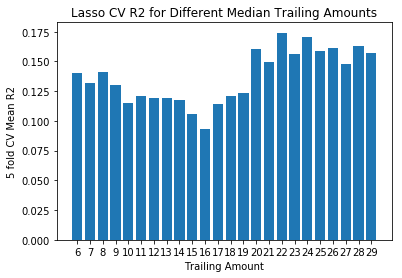

Trail Amt: 6, r2 Score: 0.1403, bestAlpha: 0.5
Trail Amt: 7, r2 Score: 0.132, bestAlpha: 0.5
Trail Amt: 8, r2 Score: 0.1411, bestAlpha: 0.5
Trail Amt: 9, r2 Score: 0.1301, bestAlpha: 0.75
Trail Amt: 10, r2 Score: 0.1154, bestAlpha: 0.75
Trail Amt: 11, r2 Score: 0.1212, bestAlpha: 0.5
Trail Amt: 12, r2 Score: 0.1195, bestAlpha: 0.5
Trail Amt: 13, r2 Score: 0.1193, bestAlpha: 0.5
Trail Amt: 14, r2 Score: 0.1178, bestAlpha: 0.5
Trail Amt: 15, r2 Score: 0.1057, bestAlpha: 0.5
Trail Amt: 16, r2 Score: 0.0928, bestAlpha: 0.5
Trail Amt: 17, r2 Score: 0.1144, bestAlpha: 0.75
Trail Amt: 18, r2 Score: 0.1209, bestAlpha: 0.5
Trail Amt: 19, r2 Score: 0.1238, bestAlpha: 1.0
Trail Amt: 20, r2 Score: 0.1607, bestAlpha: 0.5
Trail Amt: 21, r2 Score: 0.1494, bestAlpha: 0.5
Trail Amt: 22, r2 Score: 0.1741, bestAlpha: 0.75
Trail Amt: 23, r2 Score: 0.1565, bestAlpha: 0.75
Trail Amt: 24, r2 Score: 0.1707, bestAlpha: 0.75
Trail Amt: 25, r2 Score: 0.1584, bestAlpha: 0.75
Trail Amt: 26, r2 Score: 0.1612, bestA

In [498]:
display_results(trailAmtLst1, bestAlphas1, bestScores1, 'Lasso', 'Median')

In [481]:
trailAmtLst, bestAlphas, bestScores = trail_test(nba_final, trailLst, teams, team_fields, trailing_fields, [500,1000,1500], Ridge)

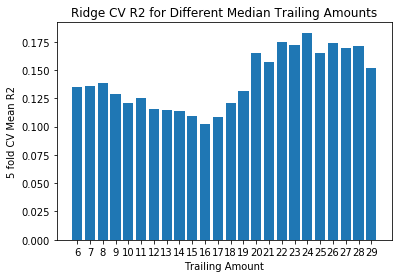

Trail Amt: 6, r2 Score: 0.1351, bestAlpha: 1000
Trail Amt: 7, r2 Score: 0.1357, bestAlpha: 1000
Trail Amt: 8, r2 Score: 0.1382, bestAlpha: 1000
Trail Amt: 9, r2 Score: 0.1292, bestAlpha: 1000
Trail Amt: 10, r2 Score: 0.1208, bestAlpha: 1000
Trail Amt: 11, r2 Score: 0.1252, bestAlpha: 1000
Trail Amt: 12, r2 Score: 0.1156, bestAlpha: 1000
Trail Amt: 13, r2 Score: 0.1146, bestAlpha: 1000
Trail Amt: 14, r2 Score: 0.1137, bestAlpha: 1000
Trail Amt: 15, r2 Score: 0.1091, bestAlpha: 1000
Trail Amt: 16, r2 Score: 0.1019, bestAlpha: 1000
Trail Amt: 17, r2 Score: 0.1082, bestAlpha: 1000
Trail Amt: 18, r2 Score: 0.1211, bestAlpha: 1000
Trail Amt: 19, r2 Score: 0.1311, bestAlpha: 1000
Trail Amt: 20, r2 Score: 0.165, bestAlpha: 500
Trail Amt: 21, r2 Score: 0.1575, bestAlpha: 1000
Trail Amt: 22, r2 Score: 0.1743, bestAlpha: 500
Trail Amt: 23, r2 Score: 0.1721, bestAlpha: 500
Trail Amt: 24, r2 Score: 0.1829, bestAlpha: 500
Trail Amt: 25, r2 Score: 0.1649, bestAlpha: 500
Trail Amt: 26, r2 Score: 0.174

In [499]:
display_results(trailAmtLst, bestAlphas, bestScores, 'Ridge', 'Median')

### Do same as above but change trailing function to mean

In [488]:
def trailAvg2(df, trailAmt, teams, team_fields, trailing_fields):
    final_df = df[['PrimKey', 'opptKey']]
    #compute trailing average
    counter = 0
    for i in teams:
        for j in [0,1]:
            temp = df[team_fields][df['teamAbbr']==i][df['Home']==j]
            for x in trailing_fields:
                temp[x+'_T'+str(trailAmt)] = temp[x].shift().rolling(window=trailAmt, min_periods = trailAmt).mean()
            if counter == 0:
                newDF = temp
            else:
                newDF = newDF.append(temp)
            counter = 1
        
    #create list with only trailing fields
    fields_t = [x for x in newDF.columns.tolist() if '_T' in x]
    fields_oppt = ['PrimKey'] + fields_t
    fields_team = ['PrimKey','MarginOfVictory', 'Home','teamDayOff_x','teamDayOff_y'] + fields_t
    
    #left join/merge with final nba sample which has only unique games with MoV, Home/Away, Days 
    df_final = final_df.merge(newDF[fields_team], how='left', left_on='PrimKey', right_on='PrimKey')
    df_final = df_final.merge(newDF[fields_oppt], how='left', left_on='opptKey',right_on='PrimKey')
    
    #remove nas and clean up duplicate columns/column names
    df_final.dropna(axis = 0, how='any', inplace=True)
    df_final.drop(columns='PrimKey_y', inplace=True)
    df_final.columns = df_final.columns.str.replace('PrimKey_x', 'PrimKey')
    df_final.reset_index(inplace=True,drop=True)
    
    #remove every other row
    home = 0
    away = 0
    for i in range(0,len(df_final),2):
        if home == away:
            df_final.drop(i,0,inplace=True)
            away += 1
        elif home < away:
            df_final.drop(i+1,0,inplace=True)
            home += 1
        elif home > away:
            df_final.drop(i,0,inplace=True)
            away += 1  
    df_final.reset_index(inplace=True,drop=True)
    

    return df_final

In [489]:
def trail_test2(df, trailAmtLst, teams, team_fields, trailing_fields, alphaLst, model):
    bestScores = []
    bestAlphas = []
    for i in trailAmtLst:
        
        #print('TrailAmt: ',str(i))
        #create new trailing average subset
        new_trail_df = trailAvg2(df, i, teams, team_fields, trailing_fields)
        
        #create list of X_columns
        X_Cols = []
        X_Cols.append('Home')
        X_Cols = [x for x in new_trail_df.columns.tolist() if '_x' in x or '_y' in x]
        
        #scale x data
        X_PCA = scale_PCA(new_trail_df[X_Cols])

        #get best lasso cross-validated score and alpha
        alpha, score = regularization(X_PCA, new_trail_df['MarginOfVictory'], model, alphaLst, 5)
        
        #append results to lists
        bestScores.append(score)
        bestAlphas.append(alpha)
        
    #bestScore = max(bestScores) # get best score
    
    #print('Best trailAmt: {}, Score: {}'.format(trailAmtLst[bestScores.index(bestScore)],bestScore)) #print it
    
    return trailAmtLst, bestAlphas, bestScores

In [500]:
trailAmtLst2, bestAlphas2, bestScores2 = trail_test2(nba_final, trailLst, teams, team_fields, trailing_fields, aLst, Lasso)

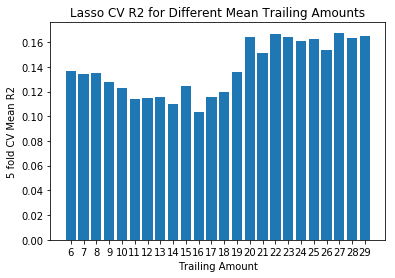

Trail Amt: 6, r2 Score: 0.1363, bestAlpha: 0.75
Trail Amt: 7, r2 Score: 0.1343, bestAlpha: 1.0
Trail Amt: 8, r2 Score: 0.1352, bestAlpha: 0.75
Trail Amt: 9, r2 Score: 0.1281, bestAlpha: 0.75
Trail Amt: 10, r2 Score: 0.1227, bestAlpha: 1.0
Trail Amt: 11, r2 Score: 0.1143, bestAlpha: 1.0
Trail Amt: 12, r2 Score: 0.1151, bestAlpha: 1.0
Trail Amt: 13, r2 Score: 0.1152, bestAlpha: 0.75
Trail Amt: 14, r2 Score: 0.1101, bestAlpha: 0.75
Trail Amt: 15, r2 Score: 0.1247, bestAlpha: 0.75
Trail Amt: 16, r2 Score: 0.1033, bestAlpha: 0.5
Trail Amt: 17, r2 Score: 0.1155, bestAlpha: 0.75
Trail Amt: 18, r2 Score: 0.1199, bestAlpha: 1.0
Trail Amt: 19, r2 Score: 0.1358, bestAlpha: 0.5
Trail Amt: 20, r2 Score: 0.1643, bestAlpha: 0.75
Trail Amt: 21, r2 Score: 0.1514, bestAlpha: 0.75
Trail Amt: 22, r2 Score: 0.1666, bestAlpha: 0.75
Trail Amt: 23, r2 Score: 0.1643, bestAlpha: 0.5
Trail Amt: 24, r2 Score: 0.161, bestAlpha: 1.0
Trail Amt: 25, r2 Score: 0.1623, bestAlpha: 0.5
Trail Amt: 26, r2 Score: 0.1532, be

In [503]:
display_results(trailAmtLst2, bestAlphas2, bestScores2, 'Lasso', 'Mean')

In [502]:
trailAmtLst3, bestAlphas3, bestScores3 = trail_test2(nba_final, trailLst, teams, team_fields, trailing_fields, [500,1000,1500], Ridge)

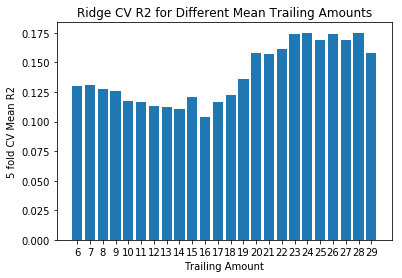

Trail Amt: 6, r2 Score: 0.1298, bestAlpha: 1000
Trail Amt: 7, r2 Score: 0.1307, bestAlpha: 1500
Trail Amt: 8, r2 Score: 0.1273, bestAlpha: 1500
Trail Amt: 9, r2 Score: 0.1256, bestAlpha: 1000
Trail Amt: 10, r2 Score: 0.1176, bestAlpha: 1500
Trail Amt: 11, r2 Score: 0.1167, bestAlpha: 1000
Trail Amt: 12, r2 Score: 0.1135, bestAlpha: 1500
Trail Amt: 13, r2 Score: 0.1126, bestAlpha: 1500
Trail Amt: 14, r2 Score: 0.1108, bestAlpha: 1500
Trail Amt: 15, r2 Score: 0.1207, bestAlpha: 1000
Trail Amt: 16, r2 Score: 0.1038, bestAlpha: 1000
Trail Amt: 17, r2 Score: 0.1167, bestAlpha: 1000
Trail Amt: 18, r2 Score: 0.1224, bestAlpha: 1000
Trail Amt: 19, r2 Score: 0.136, bestAlpha: 1500
Trail Amt: 20, r2 Score: 0.1583, bestAlpha: 500
Trail Amt: 21, r2 Score: 0.1574, bestAlpha: 1000
Trail Amt: 22, r2 Score: 0.161, bestAlpha: 1000
Trail Amt: 23, r2 Score: 0.1741, bestAlpha: 500
Trail Amt: 24, r2 Score: 0.1752, bestAlpha: 500
Trail Amt: 25, r2 Score: 0.1687, bestAlpha: 500
Trail Amt: 26, r2 Score: 0.174

In [504]:
display_results(trailAmtLst3, bestAlphas3, bestScores3, 'Ridge', 'Mean')

In [505]:
compare = pd.DataFrame()
compare['Trail_Amounts'] = trailAmtLst
compare['Lasso_TrailingMedian'] = bestScores1
compare['Ridge_TrailingMedian'] = bestScores
compare['Lasso_TrailingMean'] = bestScores2
compare['Ridge_TrailingMean'] = bestScores3

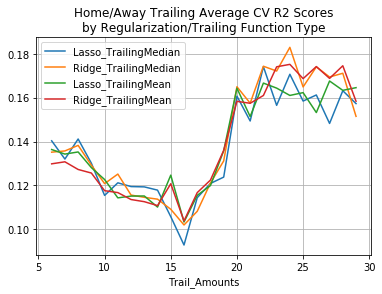

In [510]:
compare.plot(x='Trail_Amounts',kind='line', grid=True, title='Home/Away Trailing Average CV R2 Scores\nby Regularization/Trailing Function Type')